#Artificial Neural Network

In [1]:
import numpy as np
seed=42
rng=np.random.default_rng(seed=seed)

## Network Class

We shall start writing the `Network` class. The two methods that are indispensable for any ML class are:  
- fit
- predict

Fitting a neural network model required us to compute two passes on the data:
- forward
- backward

We need to start at some place by initializing the network and various hyper-parameters and this requires an `init` method:
- init

In most of these methods, we would have to take help of certain helper functions:
- activations
- losses
This is the process. But we will work through it in the reverse order so that each step of the process does not have any forward references:

`helpers -> init -> forward -> backward -> fit -> predict`

The skeleton of the class is given in the code block that follows. For ease of exposition, we are going to discuss the methods one at a time and then plug them into the class right at the end.

In [2]:
class Network:

  def init(self, layers, activation_choice='relu', output_choice='softmax', loss_choice='cce'):
    pass

  def forward(self,X):
    pass
  def backward(self,Y,Y_hat):
    pass

  def fit(self,X,Y,lr=0.01, epochs=100,
          batch_size=100):
    pass
  def predict(self,X):
    pass

## Activation functions

### Hidden Layer
We will look at two activation functions for the hidden layers. Both these functions will be applied element wise. The input to these functions can be scalars, vectors or matrices/
Sigmoid
$$g(z)=\frac{1}{1+e^{-z}}$$
ReLU
$$g(z)=\begin{cases}z, &z\geq0\\
0 & z<0
\end{cases}$$

We also need to find out the derivatives of these functions while computing the backward pass. Deriving the mathematical expressions for them are left as an exercise to the learners

In [4]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def grad_sigmoid(z):
  return sigmoid(z)*(1-sigmoid(z))

def relu(z):
  return np.where(z>=0,z,0)

def grad_relu(z):
  return np.where(z>=0,1,0)

# A dictionary of activation functions
# will be used while intializing the network
hidden_act = {'sigmoid':sigmoid, 'relu':relu}
grad_hidden_act={'sigmoid':grad_sigmoid,'relu':grad_relu}

## Output Layer
We will look at two activation functions for the output layer. Identity for regression and Softmax for classification.

###Identity
$$g(z)=z$$

###Softmax
The input to the softmax function will always be a matrix of size $n\times k$ where k is the number of classes. Since we need a probability distribution for each data-point, the softmax will be computed row-wise
 $$g(z)=\Large{[...\frac{e^{z_i}}{\sum e^{z_j}}....]}$$ 
 to avoid the overflow, we will subtract the row-wise maximum from each row while computing the softmax.


In [5]:
def identity(z):
  return z

def softmax(z):
  """
  Row-wise softmax
  """
  #check if z is a matrix
  assert z.ndim==2
  # To prevent overflow, subtract max, row wise
  z-=z.max(axis=1, keepdims=True)
  #Compute rowwise softmax
  prob=np.exp(z)/np.exp(z).sum(axis=1, keepdims= True)
  #Check if row is probability distribution
  assert np.allclose(prob.sum(axis=1),np.ones(z.shape[0]))
  return prob

output_act={'softmax':softmax, 'identity':identity}
  

##Loss
There are two types of losses we will use, least square error for regression and categorical cross-entropy for classification

### Least Square
- y is a vector of target labels for n data-points
- $\hat{y}$ is the output of the network and corresponds to the predicted labels.

$$L(y,\hat{y})=\frac{1}{2}.(\hat{y}-y)^T(\hat{y}-y)$$
### Categorical Cross-Entropy
- Y is a matrix of target labels for n data-points
- $\hat{Y}$ is the output of the network and corresponds to the predicted probabilities
$$L(Y,\hat{Y})=-1_n^T(Y\bigodot log\hat{Y})1_k$$
In our implementation,we will assume that the arguments to the loss function are always matrices of size $n \times k$. In case of regression, k=1.


In [6]:
def least_square(y,y_hat):
  return 0.5*np.sum((y_hat-y)*(y_hat-y))

def cce(Y, Y_hat):
  return -np.sum(Y*np.log(Y_hat))

losses={'least_square':least_square,'cce':cce}

## Initialization
Here will look at two parts:
- Network architecture
- Weight initialization

## Network architecture
The follwing components mainly determine the structure of the network:
- number of layers
- number of neurons per layer

We will use $l$ to index the layers. The network has L layers in all.
- $l=0$: input layer
- $1\leq l \leq L-1:$ Hidden layers
- $l=L$: Output Layer

We shall represent the number of layers and the neurons using a list `layers`. The variable L will never make an explicit appearance anywhere, instead we will use `range(len(layers))` to iterate through the layers.


One useful task is to compute the total number of parameters in the network. This will come in handy later on

In [8]:
def count_params(layers):
  num_params=0
  for l in range(1,len(layers)):
    num_weights= layers[l-1]*layers[l]
    num_biases=layers[l]
    num_params+=(num_weights +num_biases)
  return num_params

assert count_params([64,5,10]) == (64*5+5)+(5*10+10)

## Parameter initialisation

The weight-matrix at layer $l$ has size `layer[l-1]*layers[l]`.The bias at layer $l$ is a vector of size `layers[l]`. We will stoire all these weights in a list W of the same size as layers. `W[l]` would correspond to $W_1$. Since there are L weight matrices, `W[0]` would be set to `None.` Recall that the size of the list is L+1. A similar list would be required for b.

To make the gradient descent update simpler, it will be useful to a have a **master vector,$\theta$** that has a reference to all the parameters in the network. We will do the same for the gradients $\theta^{(g)}$. So whenver $\theta$ is updated, the weights $W_1$ will also be updated and vice-versa.

One way to do this is to first start with the master vector and then reshape chunks of it into the dimensions of a weight matrix. Reshaping an array usually returns a view of an array and not a copy. To understand this function better, refer to Numpy's documentation on "Copies and Views"

In [11]:
def init_params(layers):
  num_params = count_params(layers)

  W= [None for _ in range(len(layers))]   #weights
  b= [None for _ in range(len(layers))]   # biases
  gW= [None for _ in range(len(layers))]  # grad loss w.r.t weights
  gb= [None for _ in range(len(layers))]  # grad ;pss w.r.t biases

  # Sample from N(0,1) to initialize the params\
  theta = rng.standard_normal(num_params)   #master params
  gtheta = np.zeros(num_params)             # master grads

  # (start, end) specify the portion of the theta
  # that corresponds to the parameter, W_1 or b_1
  start, end =0, 0
  for l in range(1, len(layers)):
    #Reshape the section (Start, end) and assign it to W[1]
    end= start+layers[l-1]*layers[l]
    W[l]=theta[start:end].reshape(layers[l-1],layers[l])
    gW[l]=gtheta[start:end].reshape(layers[l-1],layers[l])

    #Reshape the section (start, end) and assign it to b[1]
    start, end = end, end+layers[l]
    b[l]=theta[start:end].reshape(layers[l])
    gb[l]=gtheta[start:end].reshape(layers[l])
    start=end

  return theta, gtheta, W, b, gW, gb

## Test init params
layers = [64,32,10]
params = init_params([64,32,10])
for l in range(1, len(layers)):
  # Check if the weights are views of the master vector
  assert params[2][l].base is params[0]
  assert params[3][l].base is params[0]
  assert params[4][l].base is params[1]
  assert params[5][l].base is params[1]
  

In [16]:
print(params[2][1])
print('________________')
print(params[2][1].base)
print('________________')
print(params[0])

[[-0.47100026 -0.67231587  1.46972376 ...  0.02454983 -0.32134253
  -0.20118976]
 [ 2.0371279  -1.76200024 -0.23467682 ...  0.27200111 -0.62831999
  -0.27836644]
 [ 0.44135869 -0.34877268  0.22605959 ... -1.08830779  1.19681671
   0.10231033]
 ...
 [ 0.02975074 -0.26400449 -1.16775192 ...  1.05053365 -0.1231803
   0.61157937]
 [ 0.67101243 -0.45244034  1.09190644 ... -1.13826398  0.39963069
   0.01438969]
 [ 0.34750931 -0.51977195  1.38313514 ...  0.48117409 -0.58571153
   0.14687517]]
________________
[-0.47100026 -0.67231587  1.46972376 ...  0.53943852 -0.93714921
  0.91823253]
________________
[-0.47100026 -0.67231587  1.46972376 ...  0.53943852 -0.93714921
  0.91823253]


In [17]:
def init(self, layers, activation_choice='relu',
         output_choice='softmax',
         loss_choice='cce'):
  self.layers=layers

  #Parameters and gradients
  self.theta, self.gtheta, self.W, self.b, self.gW, self.gb=init_params(layers)

  #Activation functions
  self.ghid=hidden_act[activation_choice]
  self.grad_ghid = grad_hidden_act[activation_choice]
  self.gout = output_act[output_choice]

  #Loss
  self.loss=losses[loss_choice]

## Forward Pass
The foward pass algorithm is as follows. First, we initialize **$A_0=X$**. Then, we iteratively compute the pre-activations and the activations for every layer l uysing the equations given below:
$$Z_l=A_{l-1}W_l+b_l$$
$$A_l=g(Z_l)$$
 finally the output is given by $\hat{y}=A_L$
 

In [18]:
def forward(self,X):
  self.Z=[None for _ in range(len(self.layers))]
  self.A=[None for _ in range(len(self.layers))]
  self.A[0]=X
  self.Z[0]=X

  for l in range(1, len(self.layers)):
    self.Z[l]=self.A[l-1]@self.W[l]+self.b[l]
    self.A[l]=self.ghid(self.Z[l])

  self.A[-1]=self.gout(self.Z[-1])
  return self.A[-1]

## Backward PAss
The backward pass algorithm is as follows. We first initalize the gradienbts of the pre-activations at layer L as $Z_L^{(g)}=\hat{Y}-Y$. It is fortunate that this is true for both regression and classification!. The other gradients can then be iteratively updated using these equations:
![image info](https://bit.ly/3cvus3Y)

An important point ot note is the use of `self.gW[1][:,:]` while updating the gradient of the weights and not `self.gW[l].``self.gW[l][:,:]` does an in-place update, thus maintaining a link with the master params, namely `self.theta`

In [29]:
def backward(self,Y,Y_hat):
  gZ=[None for _ in range(len(self.layers))]
  gA=[None for _ in range(len(self.layers))]
  gZ[-1]=Y_hat - Y

  for l in range(len(self.layers)-1,0,-1):
    self.gW[l][:,:]=self.A[l-1].T@gZ[l]
    self.gb[l][:]=np.sum(gZ[l].T, axis=1)
    gA[l-1]=gZ[l]@self.W[l].T
    gZ[l-1]=gA[l-1]*self.grad_ghid(self.Z[l-1])

##Fit

In [21]:
def fit(self,X,Y,lr=0.01,
        epochs=100,
        batch_size=100):
  self.losses=[]

  for epoch in range(epochs):
    #Compute the loss
    Y_hat=self.forward(X)
    self.losses.append(self.loss(Y,Y_hat))
    #Shuffle the dataset
    indices=np.arange(X.shape[0])
    #Use rng.shuffle to maintain reproducibility
    rng.shuffle(indices)
    X,Y=X[indices], Y[indices]
    #Number of batches
    num_batches = X.shape[0]//batch_size
    #Mini-batch GD
    for b in range(num_batches):
      Xb=X[b*batch_size:(b+1)*batch_size]
      Yb=Y[b*batch_size:(b+1)*batch_size]
      #Compute the predictions for this batch
      Y_hat_b=self.forward(Xb)
      #Compute the gradients for this batch
      self.backward(Yb,Y_hat_b)
      #Update the gradients of all parameters
      # -= is used for inplace update
      self.theta -= lr*self.gtheta

## Predict

In [22]:
def predict(self,X):
  Y_hat=self.forward(X)
  #regression
  if X.shape[-1]==1:
    return Y_hat
  #classification
  else:
    return np.argmax(Y_hat,axis=1)

## Plugging in

In [31]:
Network.__init__=init
Network.forward=forward
Network.backward=backward
Network.fit=fit
Network.predict=predict

##DAta

Sample image with label 0
(1797, 8, 8)


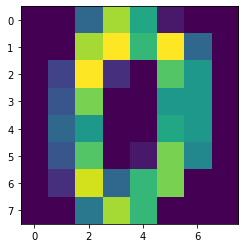

In [24]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits=load_digits()

X=digits.images
#Normalize the data so that all features lie in (0,1)
X /=np.max(X)
y=digits.target
plt.imshow(X[0])
print(f'Sample image with label {y[0]}')
print(X.shape)

#Reshpe input
X= X.reshape(-1,64)
#Input size
isize=X.shape[-1]

#Output size
osize=len(np.unique(y))


In [25]:
def one_hot_encoder(y):
  k=len(np.unique(y))
  return np.eye(k)[y]
  

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    random_state=seed)
Y_train=one_hot_encoder(y_train)
Y_test = one_hot_encoder(y_test)


##Fit!?

TEst-data size=719
Accuracy=96.52
Number of parameters=2410


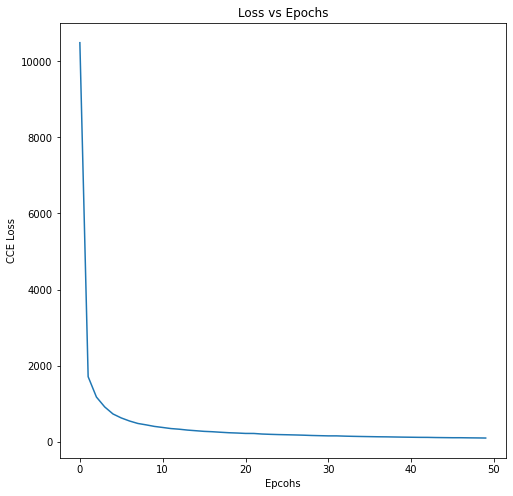

In [32]:
layers=[isize, 32,osize]
network =Network(layers, activation_choice='sigmoid',
                          output_choice='softmax',
                          loss_choice='cce')
#Fit the network on the data
epochs=50
network.fit(X_train, Y_train, lr=0.01, epochs=epochs, batch_size=10)

#Plot the losses
plt.figure(figsize=(8,8))
plt.plot(range(epochs),network.losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epcohs')
plt.ylabel('CCE Loss')

#Compute the accuracy
accuracy= np.sum(network.predict(X_test)==y_test)/X_test.shape[0]*100
print(f'TEst-data size={X_test.shape[0]}')
print(f'Accuracy={accuracy:.2f}')
print(f'Number of parameters={count_params(layers)}')